In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn import datasets
from skimage import io, color, transform
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [3]:
df = pd.read_csv("./dataset/SB-FishDisease.csv")

In [4]:
df['target'].value_counts()

target
disease    268
healthy    155
Name: count, dtype: int64

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sickness'], random_state=42)

print("Träningsuppsättning:")
print(train_df['sickness'].value_counts())

print("\nTestuppsättning:")
print(test_df['sickness'].value_counts())

Träningsuppsättning:
sickness
healthy_fish                         113
bacterial_gill disease                43
fungal_diseases_saprolegniasis        37
bacterial_diseases _aeromoniasis      37
bacterial_red disease                 36
viral_diseases_white_tail_disease     33
parasitic_diseases                    28
healthy_gills                         11
Name: count, dtype: int64

Testuppsättning:
sickness
healthy_fish                         28
bacterial_gill disease               11
bacterial_diseases _aeromoniasis     10
fungal_diseases_saprolegniasis        9
bacterial_red disease                 9
viral_diseases_white_tail_disease     8
parasitic_diseases                    7
healthy_gills                         3
Name: count, dtype: int64


In [6]:
def prepare_images(file_paths, target_size=(64, 64)):
    images = []
    for path in file_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

In [7]:
X_train = prepare_images(train_df['path'])
X_test = prepare_images(test_df['path'])

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df['target'])
y_test_encoded = label_encoder.transform(test_df['target'])

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)


# Skapa CNN-modell
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Antalet klasser: 2 (sjuk eller inte sjuk)

# Kompilera modellen
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Träna modellen
model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2)

# Utvärdera modellen på testdata
y_pred_categorical = model.predict(X_test)
y_pred = np.argmax(y_pred_categorical, axis=1)

# Konvertera tillbaka från one-hot encoding
y_test_encoded_inverse = label_encoder.inverse_transform(y_test_encoded)
y_pred_inverse = label_encoder.inverse_transform(y_pred)

# Utvärdera modellen
accuracy = accuracy_score(y_test_encoded_inverse, y_pred_inverse)
print(f"Accuracy: {accuracy}")

# Visa annan utvärderingsinformation
print(classification_report(y_test_encoded_inverse, y_pred_inverse))
print(confusion_matrix(y_test_encoded_inverse, y_pred_inverse))




Epoch 1/10


9/9 [==============================] - 1s 61ms/step - loss: 52.1630 - accuracy: 0.5556 - val_loss: 2.1069 - val_accuracy: 0.3529
Epoch 2/10
9/9 [==============================] - 0s 55ms/step - loss: 1.0139 - accuracy: 0.5259 - val_loss: 0.7484 - val_accuracy: 0.6618
Epoch 3/10
9/9 [==============================] - 0s 31ms/step - loss: 0.6738 - accuracy: 0.6481 - val_loss: 0.5049 - val_accuracy: 0.7206
Epoch 4/10
9/9 [==============================] - 0s 33ms/step - loss: 0.5383 - accuracy: 0.7222 - val_loss: 0.5894 - val_accuracy: 0.6912
Epoch 5/10
9/9 [==============================] - 0s 33ms/step - loss: 0.4851 - accuracy: 0.7778 - val_loss: 0.7228 - val_accuracy: 0.5735
Epoch 6/10
9/9 [==============================] - 0s 34ms/step - loss: 0.4803 - accuracy: 0.7630 - val_loss: 0.5015 - val_accuracy: 0.6912
Epoch 7/10
9/9 [==============================] - 0s 35ms/step - loss: 0.3354 - accuracy: 0.8667 - val_loss: 0.4675 - val_accuracy: 0.7206
Epoch 8/10
9/9 [=====

In [9]:
def random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("Inga bilder hittades i mappen.")
        return None

    random_image = random.choice(image_files)

    img_path = os.path.join(folder_path, random_image)

    return img_path

./dataset/YOLOstacked/images/Bacterial_Red_disease_14.jpg
1/1 [==============================] - 0s 25ms/step
Predicted Class: Diseased
Confidence Score: 0.8820655941963196


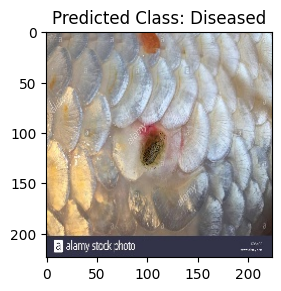

In [22]:
folder_path = './dataset/YOLOstacked/images/'
test_image_path = random_image(folder_path)
print(test_image_path)
test_image = prepare_images([test_image_path])
prediction = model.predict(test_image)

predicted_class_index = np.argmax(prediction[0])
confidence_score = prediction[0][predicted_class_index]

class_labels = ["Diseased", "Healthy"]
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted Class: {predicted_class_label}")
print(f"Confidence Score: {confidence_score}")

original_image = io.imread(test_image_path)

plt.subplot(1, 2, 2)
plt.imshow(original_image)
plt.title(f'Predicted Class: {predicted_class_label}')

plt.show()